# Data Science and Machine Learning Assignment WiSe 25/26

In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import missingno as msno
import time
import warnings
warnings.filterwarnings("ignore")
from tabulate import tabulate

from matplotlib.ticker import FuncFormatter
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.metrics import mean_squared_error as MSE, RocCurveDisplay, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# options to make the printed notebook more compact
from IPython.display import HTML
HTML('''<style>
pre, code { font-size: 9px !important; line-height: 1.3 !important; }
.jp-OutputArea-output { margin: 0 !important; }
.dataframe td { white-space: pre-wrap !important; }
</style>''')
pd.set_option('display.precision', 3)

Dataset:

This dataset contains customer information from a European FinTech startup that offers various
financial products including banking, credit cards, and investment services. The dataset is designed
for educational purposes to practice multiple machine learning tasks within a realistic business
context.

In [154]:
FinTech = pd.read_csv("../Hausarbeit/dataset.csv")
print(f"Dataset shape: {FinTech.shape}")

Dataset shape: (8662, 22)


In [155]:
FinTech.head(5)

,Customer_ID,CCreditScore,CGeography,CGender,CAge,CTenure,CBalance,CNumOfProducts,CHasCrCard,CIsActiveMember,...,Account_Age_Months,Avg_Monthly_Transactions,Transaction_Variance,Last_Login_Days_Ago,Support_Tickets_Count,Mobile_App_Usage_Hours,Onboarding_Month,Is_Holiday_Onboarding,Churn,CLV_Continuous
0,CUST_000001,553.295,France,Male,39,2,131008.169,1,1,0,...,36.942,8,4.959,1.095,1,7.980,8,0,0,21696.256
1,CUST_000002,552.939,France,Male,33,4,118529.789,1,0,0,...,23.749,11,9.867,14.810,0,11.565,11,0,0,15918.891
2,CUST_000003,688.746,Spain,Male,40,1,-879.725,2,1,1,...,1.115,13,6.178,26.434,0,3.332,2,0,0,10361.316
3,CUST_000004,771.941,France,Male,40,9,125563.133,1,1,0,...,1.663,12,4.509,18.540,2,12.715,1,1,0,15189.776
4,CUST_000005,484.093,France,Male,55,5,95759.919,1,0,1,...,24.008,8,18.787,11.894,1,0.720,2,0,0,14631.815


### Business Problem:

The FinTech startup faces several analytical challenges that require different machine learning
approaches:
1. Customer Churn Prediction: Identify customers who are likely to leave the platform
2. Customer Lifetime Value Prediction: Estimate the monetary value each customer will
generate
3. Customer Segmentation: Group customers into distinct segments for targeted marketing
strategies

### Target variables:
1. Churn (Binary Classification)
- Description: Whether the customer has left the platform
- Values: 0 = No Churn, 1 = Churn
- Distribution: Imbalanced (majority No Churn)
2. CLV_Continuous (Regression)
- Description: Customer Lifetime Value in monetary terms
- Values: Continuous numeric values in dollars
- Range: Varies significantly across customers

### Features:
The dataset include a wide range of features, including demographic variables, temporal and behavioral features. Please check the assignment sheet for further information.

# Classification Tasks

## Task 1: Data Preprocessing

Before you can build your models, prepare the dataset for analysis. 
- Apply your data preprocessing knowledge to thoroughly clean and prepare the dataset 
before training.

Since we are doing the preporcessing in order to build machine learning models we have to keep in mind that not all preprocessing steps can be applied on the whole dataset. Splitting the dataset into a training and a test dataset is neccessary. 

The test data should be representative of the data that the model is expected to encounter in real-life scenarios. Hence the test data should be in the same format and distribution as the data that the model will be used on in the future. Therefore it is important to separate the test from the training data at ta certain point and conduct certain pre-processing steps on the training data separately.

Some steps from the Data Pre-Processing Checklist can be applied on the full dataset, which includes:
- Examine data distribution and variable types
- Check for Inconsistencies

If values are imputed during these steps it is due to data entry errors or logical constraints. These changes do not negatively effect the application on real-world data. 

### Initial Data Analysis

This section provides an initial descriptive overview of the dataset to better understand the distribution and structure of the features used in the modeling task.

In [156]:
FinTech.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8662 entries, 0 to 8661
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_ID               8662 non-null   object 
 1   CCreditScore              8662 non-null   float64
 2   CGeography                8662 non-null   object 
 3   CGender                   8662 non-null   object 
 4   CAge                      8662 non-null   int64  
 5   CTenure                   8662 non-null   int64  
 6   CBalance                  8585 non-null   float64
 7   CNumOfProducts            8662 non-null   int64  
 8   CHasCrCard                8662 non-null   int64  
 9   CIsActiveMember           8662 non-null   int64  
 10  CEstimatedSalary          7884 non-null   float64
 11  Days_Since_Onboarding     8662 non-null   float64
 12  Account_Age_Months        8662 non-null   float64
 13  Avg_Monthly_Transactions  8662 non-null   int64  
 14  Transact

Compute percentage of missing values:

In [157]:
print((FinTech.isnull().sum()/len(FinTech))*100)

Customer_ID                 0.000
CCreditScore                0.000
CGeography                  0.000
CGender                     0.000
CAge                        0.000
CTenure                     0.000
CBalance                    0.889
CNumOfProducts              0.000
CHasCrCard                  0.000
CIsActiveMember             0.000
CEstimatedSalary            8.982
Days_Since_Onboarding       0.000
Account_Age_Months          0.000
Avg_Monthly_Transactions    0.000
Transaction_Variance        0.000
Last_Login_Days_Ago         0.000
Support_Tickets_Count       0.000
Mobile_App_Usage_Hours      0.000
Onboarding_Month            0.000
Is_Holiday_Onboarding       0.000
Churn                       0.000
CLV_Continuous              0.000
dtype: float64


- The dataset contains 8662 observations and 22 variables. 
- There are different datatypes, object, int64 and float64.
- The target variables, `Churn` and `CLV_Continuous`, are complete and contain no missing values.
- The predictors are mostly complete:
    -  Only `CBalance` (percentage of missingness: 0,89 %) and `CEstimatedSalary` (8,98 %) contain missing values.

In [158]:
FinTech.describe()

,CCreditScore,CAge,CTenure,CBalance,CNumOfProducts,CHasCrCard,CIsActiveMember,CEstimatedSalary,Days_Since_Onboarding,Account_Age_Months,Avg_Monthly_Transactions,Transaction_Variance,Last_Login_Days_Ago,Support_Tickets_Count,Mobile_App_Usage_Hours,Onboarding_Month,Is_Holiday_Onboarding,Churn,CLV_Continuous
count,8662.000,8662.000,8662.000,8585.000,8662.000,8662.000,8662.000,7884.000,8662.000,8.662e+03,8662.000,8662.000,8662.000,8662.000,8662.000,8662.000,8662.000,8662.000,8662.000
mean,650.540,38.452,5.024,73768.694,1.536,0.706,0.542,100456.169,403.245,1.344e+01,11.986,7.922,16.045,0.518,5.003,6.466,0.173,0.074,13665.886
std,99.007,23.231,2.883,62813.135,0.533,0.456,0.498,57500.207,398.681,1.329e+01,3.460,5.670,11.474,0.795,5.073,3.466,0.378,0.262,5443.762
min,0.000,-1.000,0.000,-7218.834,1.000,0.000,0.000,-3666.109,0.019,6.339e-04,1.000,0.013,0.101,0.000,0.001,1.000,0.000,0.000,1428.028
25%,584.429,31.000,3.000,732.953,1.000,0.000,0.000,51236.857,115.675,3.856e+00,10.000,3.692,7.746,0.000,1.434,3.000,0.000,0.000,9062.956
50%,652.875,36.000,5.000,93650.834,2.000,1.000,1.000,100947.390,278.752,9.292e+00,12.000,6.656,13.249,0.000,3.472,6.000,0.000,0.000,14016.568
75%,717.470,42.000,7.000,126845.364,2.000,1.000,1.000,149353.872,562.317,1.874e+01,14.000,10.600,21.511,1.000,6.814,9.000,0.000,0.000,18003.114
max,857.458,999.000,10.000,220214.292,4.000,1.000,1.000,204659.480,3664.777,1.222e+02,28.000,45.260,110.096,6.000,45.201,12.000,1.000,1.000,29123.503


### Investigate target variables

As a last step of the data examination we are going to look at the binary target variable `Churn` that is relevant for the classification task. In this assignment we are not analyzing `CLV_Continuous`, check assignment 2 for this.

In [159]:
FinTech.Churn.value_counts()

Churn
0    8021
1     641
Name: count, dtype: int64

Class Imbalance! There are significantly less entries with `Churn` == True in this dataset. 

Since the target variable `Churn` indicates whether a customer leaves the platform, this means that significantly more customers are included in the dataset, that did not leave the platform. 
We have to take this into account when we build the models.

### Exploratory data analysis and preprocessing

This section explores and prepares the dataset for modeling by examining feature distributions, identifying potential issues, and applying appropriate preprocessing steps.
First we are investigating the numeric feature distributions:

In [160]:
exclude = ['Churn', 'CLV_Continuous', 'Customer_ID']
all_cols = [col for col in FinTech.columns if col not in exclude]

In [161]:
def plot_grid(df, cols, ncols=4, fig_height=2, plot_type='auto'):
    """Plot columns in a grid layout.
    plot_type: 'auto', 'hist', 'box', or 'count'
    """
    for row_start in range(0, len(cols), ncols):
        row_cols = cols[row_start:row_start + ncols]
        fig, axes = plt.subplots(1, ncols, figsize=(ncols * 2.5, fig_height))
        
        for i, col in enumerate(row_cols):
            ax = axes[i]
            data = df[col]
            
            if plot_type == 'box':
                sns.boxplot(x=data, ax=ax, color='blue', orient='h')
            elif plot_type == 'count' or (plot_type == 'auto' and data.nunique() <= 10):
                sns.countplot(x=data, ax=ax, color='blue')
                ax.tick_params(axis='x', rotation=45, labelsize=7)
            else:
                sns.histplot(x=data, ax=ax, color='blue')
                ax.tick_params(axis='x', labelsize=7)
            
            title = col.replace('num__', '').replace('cat__', '').replace('bin__', '')
            ax.set_title(title, fontsize=9)
            ax.set_xlabel('')
            ax.set_ylabel('')
        
        for i in range(len(row_cols), ncols):
            axes[i].axis('off')
        plt.subplots_adjust(wspace=0.3)
        plt.show()

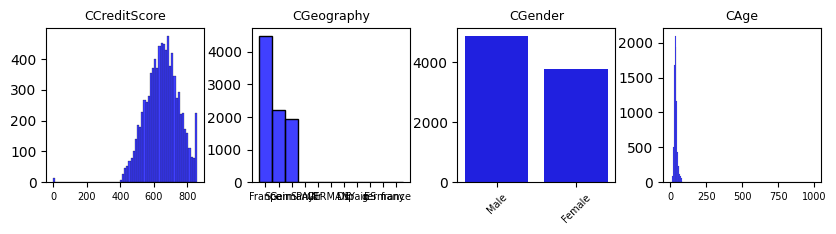

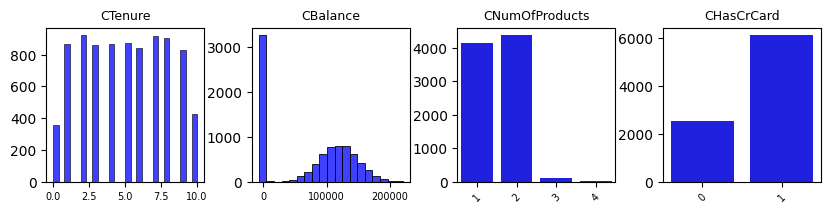

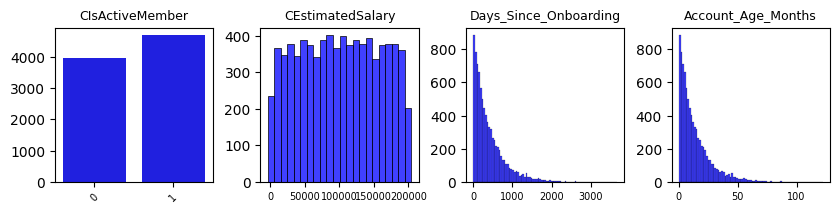

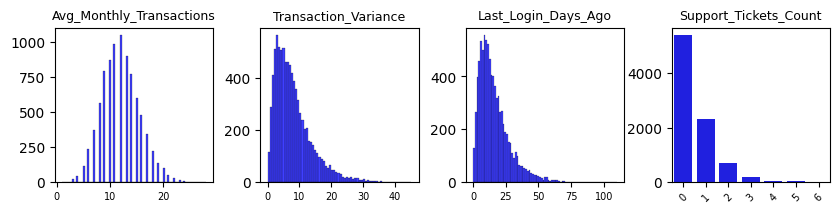

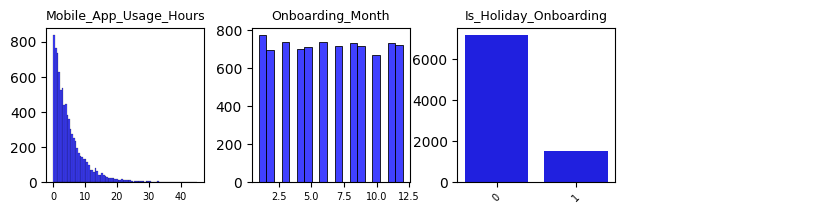

In [162]:
plot_grid(FinTech, all_cols, ncols=4, fig_height=2)

Several data quality issues can be seen when we look at these distributions and at the results of .describe() from earlier:
1. There are invalid values for `CAge`. `CCreditScore` and `CEstimatedSalary`.
2. As said before both `CBalance` and `CEstimatedSalary` have missing values.
3. Format inconsistencies for `CGeorgraphy`.
4. Many right-skewed distributions, like for `Days_Since_Onboarding`,`Account_Age_Months`, `Transaction_Variance`, `Last_Login_Days_Ago` and `Mobile_App_Usage_hours`.
5. Only some distributions are similar to a normal or uniform distribution, like `CTenure`, `CEstimatedSalary` and `Onboarding_Month`. Data transformation will be necessary.

To tackle these data quality issues we are going to apply pre-processing steps according to the DaPy Data Pre-Processing Checklist.
Before doing this we are going to create a copy of the dataset:

In [163]:
FinTech_cleaned = FinTech.copy()

### Check for Inconsistencies

As a first step we are going to look for format inconsistencies. We are going to apply cleaning steps for all columns with values that have the object datatype.

In [164]:
def clean_obj_cols(df):
    obj_cols = df.select_dtypes(include=["object"]).columns
    for col in obj_cols:
        df[col] = df[col].str.strip().str.capitalize()
    return df

FinTech_cleaned = clean_obj_cols(FinTech_cleaned)

After this we are going to handle the variations in spelling seen before by looking at the unique values in the columns `CGeography` an `CGender`.

In [165]:
text_cols = ["CGeography", "CGender"]
for col in text_cols:
    print(f"{col} unique values: {FinTech_cleaned[col].unique()}")

CGeography unique values: ['France' 'Spain' 'Germany' 'Fr' 'De' 'Es']
CGender unique values: ['Male' 'Female']


We can see that there are variations in spelling in `CGeography`. We will standardize the spelling by mapping the values.

In [166]:
geography_mapping = {
    "Fr": "France",
    "De": "Germany",
    "Es": "Spain"
}
FinTech_cleaned["CGeography"] = FinTech_cleaned["CGeography"].replace(geography_mapping)
print(f"CGeography unique values after cleaning: {FinTech_cleaned["CGeography"].unique()}")

CGeography unique values after cleaning: ['France' 'Spain' 'Germany']


Next we are checking for complete duplicates in the dataset and remove them if any exist.

In [167]:
def drop_duplicates(df):
    initial_shape = df.shape
    df = df.drop_duplicates()
    final_shape = df.shape
    print(f"Dropped {initial_shape[0] - final_shape[0]} duplicate rows.")
    return df
FinTech_cleaned = drop_duplicates(FinTech_cleaned)

Dropped 0 duplicate rows.


Next we are checking for duplicate entries for the unique identifier "Customer_ID".

In [168]:
print(f"There are {FinTech_cleaned["Customer_ID"].duplicated().sum()} duplicate CustomerID entries.")

There are 0 duplicate CustomerID entries.


Now we will check for logical inconsistencies in our numerical columns by defining valid ranges for each variable and identifying any violations. `CAge` for example, can not include any negative values. We handle these nge violations with median imputation.

In [169]:
valid_ranges = {
    "CCreditScore": (0, None), "CAge": (0, 125), "CTenure": (0, None),
    "CNumOfProducts": (1, 4), "CHasCrCard": (0, 1), "CIsActiveMember": (0, 1),
    "CEstimatedSalary": (0, None), "Days_Since_Onboarding": (0, None),
    "Account_Age_Months": (0, None), "Avg_Monthly_Transactions": (0, None),
    "Transaction_Variance": (0, None), "Last_Login_Days_Ago": (0, None),
    "Support_Tickets_Count": (0, None), "Mobile_App_Usage_Hours": (0, None),
    "Onboarding_Month": (1, 12), "Is_Holiday_Onboarding": (0, 1),
    "Churn": (0, 1), "CLV_Continuous": (0, None)
}

def check_and_fix_ranges(df, ranges, fix):
    """Check for range violations and impute with median."""
    df = df.copy() if fix else df
    for col, (min_val, max_val) in ranges.items():
        if col not in df.columns:
            continue
        invalid = ((df[col] < min_val) if min_val is not None else False) | \
                  ((df[col] > max_val) if max_val is not None else False)
        n = int(invalid.sum())
        if n == 0:
            continue
        print(f"{col}: {n} violations (range: {min_val}-{max_val}, found: {df[col].min():.1f}-{df[col].max():.1f})")
        if fix:
            median = df.loc[~invalid & df[col].notna(), col].median()
            if pd.notna(median):
                df.loc[invalid, col] = median
    return df

# Check and fix violations
FinTech_cleaned = check_and_fix_ranges(FinTech_cleaned, valid_ranges, fix=True)

CAge: 11 violations (range: 0-125, found: -1.0-999.0)
CEstimatedSalary: 26 violations (range: 0-None, found: -3666.1-204659.5)


Next up we are taking a look at inconsistent relationships between variables. 

We are going to check the values if `CAge` > `CTenure`, if `Account_Age_Months` * 30 > `Last_Login_Days_Ago` and if  `Days_Since_Onboarding`/30 = `Account_Age_Months`. 

In [170]:
days_per_month = 30.44

In [171]:
def fix_constraints(df, days_per_month, tolerance_months=1):
    df = df.copy()

    # age tenure constraint
    violations = df[df['CAge'] < df['CTenure']].index
    violations_count = len(violations)
    
    if violations_count > 0:
        for idx in violations:
            df.loc[idx, 'CTenure'] = min(df.loc[idx, 'CTenure'], df.loc[idx, 'CAge'])
        print(f"Constraint 1: {violations_count} entries corrected (CAge >= CTenure)")
    else:
        print("Constraint 1: No violations  (CAge >= CTenure)")

    # onboarding account age constraint   
    expected_months_since_onboarding = df['Days_Since_Onboarding'] / days_per_month
    discrepancy = abs(df['Account_Age_Months'] - expected_months_since_onboarding)
    
    violations = df[discrepancy > tolerance_months].index
    violations_count = len(violations)
    
    if violations_count > 0:
        for idx in violations:
            df.loc[idx, 'Days_Since_Onboarding'] = df.loc[idx, 'Account_Age_Months'] * days_per_month
        print(f"Constraint 2: {violations_count} entries corrected (Onboarding ≈ Account_Age)")
    else:
        print("Constraint 2: No violations (Onboarding ≈ Account_Age)")

    # temporal consistency account age and last login

    account_age_days = df['Account_Age_Months'] * days_per_month
    violations = df[df['Last_Login_Days_Ago'] > account_age_days].index
    violations_count = len(violations)
    
    if violations_count > 0:
        for idx in violations:
            account_age_in_days = df.loc[idx, 'Account_Age_Months'] * days_per_month
            df.loc[idx, 'Last_Login_Days_Ago'] = max(1, account_age_in_days - 1)
        print(f"Constraint 3: {violations_count} entries corrected (Last_Login <= Account_Age)")
    else:
        print("Constraint 3: No violations (Last_Login <= Account_Age)")

    return df

In [172]:
FinTech_cleaned =fix_constraints(FinTech_cleaned, days_per_month)

Constraint 1: No violations  (CAge >= CTenure)


Constraint 2: 40 entries corrected (Onboarding ≈ Account_Age)
Constraint 3: 322 entries corrected (Last_Login <= Account_Age)


After fixing the logical inconsistencies we are taking a look at data entry errors. 

We already checked the categorical (text) variables for typos (`CGeography`, `CGender`). 
Next we have to see if there are any outliers or extreme values that are likely due to data entry mistakes. 

First we are going to create a subset with all variables without value ranges. Because we fixed range violations before, these are the only variables where outliers can occur.

In [173]:
numeric_cols = ['CCreditScore', 'CAge', 'CTenure', 'CBalance', 'CEstimatedSalary',
                'Days_Since_Onboarding', 'Account_Age_Months', 'Avg_Monthly_Transactions',
                'Transaction_Variance', 'Last_Login_Days_Ago', 'Support_Tickets_Count',
                'Mobile_App_Usage_Hours']

cols = [c for c in numeric_cols if c in FinTech_cleaned.columns]

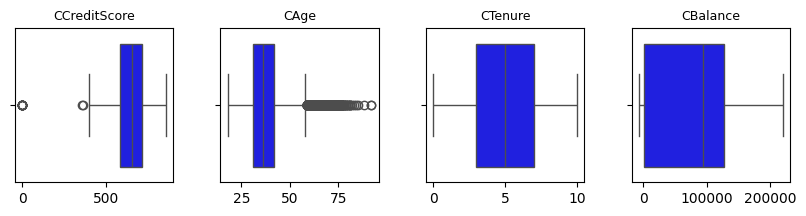

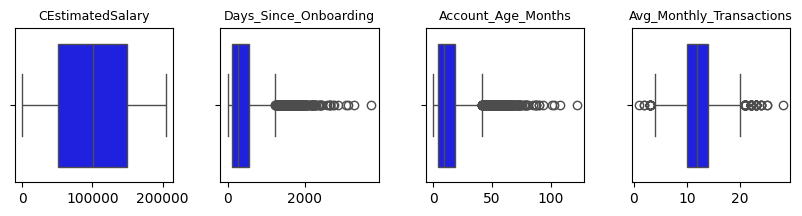

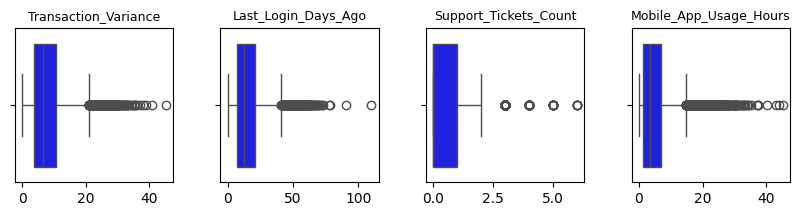

In [174]:
plot_grid(FinTech_cleaned, cols, ncols=4, plot_type='box')

Except from `CTenure`, `CBalance` and `CEstimatedSalary` all other features have outliers, while most of the distributions are skewed to the right, as seen before. Looking at the distribution of the outliers there do not seem to be any extreme values. We already ensured that the valid ranges are not violated.

The only noticeable outlier is found for `CCreditScore`. We can see that there are values with `CCreditScore` equals 0. We are going to take a closer look next:

In [175]:
print(FinTech_cleaned['CCreditScore'].sort_values(ascending=True).head(15))

1194      0.000
3030      0.000
8576      0.000
1140      0.000
6331      0.000
6965      0.000
199       0.000
2108      0.000
7082      0.000
4371      0.000
1539      0.000
1169      0.000
7275      0.000
5222    356.806
7116    363.927
Name: CCreditScore, dtype: float64


Since it is not unrealistic that the scale for `CCreditScore` includes the value 0, we are keeping these values untouched. 

### Data Splitting

The following preprocessing steps can not be applied to the full dataset, because there is a risk of data leakage when imputing missing values or when handling outliers. Therefore we are going to split the data now:

In [176]:
# define features and target
X = FinTech_cleaned.drop(columns=["Churn", "CLV_Continuous", "Customer_ID"])
y = FinTech_cleaned["Churn"]

X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

The dataset is very imbalanced and `Churn` == True is underrepresented. Therefore we set stratify=y to apply stratification. This ensures that both training and test sets represent the true distribution of classes. Otherwhise randomly splitting might lead to training or test sets with few samples of the minority class (`Churn`=1), which could bias the model. The worst case that could happen without Stratification is that there is no positive value in our sample. This ould lead to calculation issues when calculating performance metrics.

It is usual to create a separate validation set as a third subset from the dataset (hold-out method) in order to evaluate the training and test set. For simplification we will use the simple 70/30 train/test split in this case.

### Check for missing values

As said at the beginning we have two variables where values are missing. To get a better understanding of the missingness pattern, we can visualize it using missingno matrices.

In [177]:
X_train_sorted_balance = X_train.sort_values(by='CBalance')
X_train_sorted_credit_score = X_train.sort_values(by='CCreditScore')
X_train_sorted_account_age = X_train.sort_values(by='Account_Age_Months')
X_train_sorted_salary = X_train.sort_values(by='CEstimatedSalary')

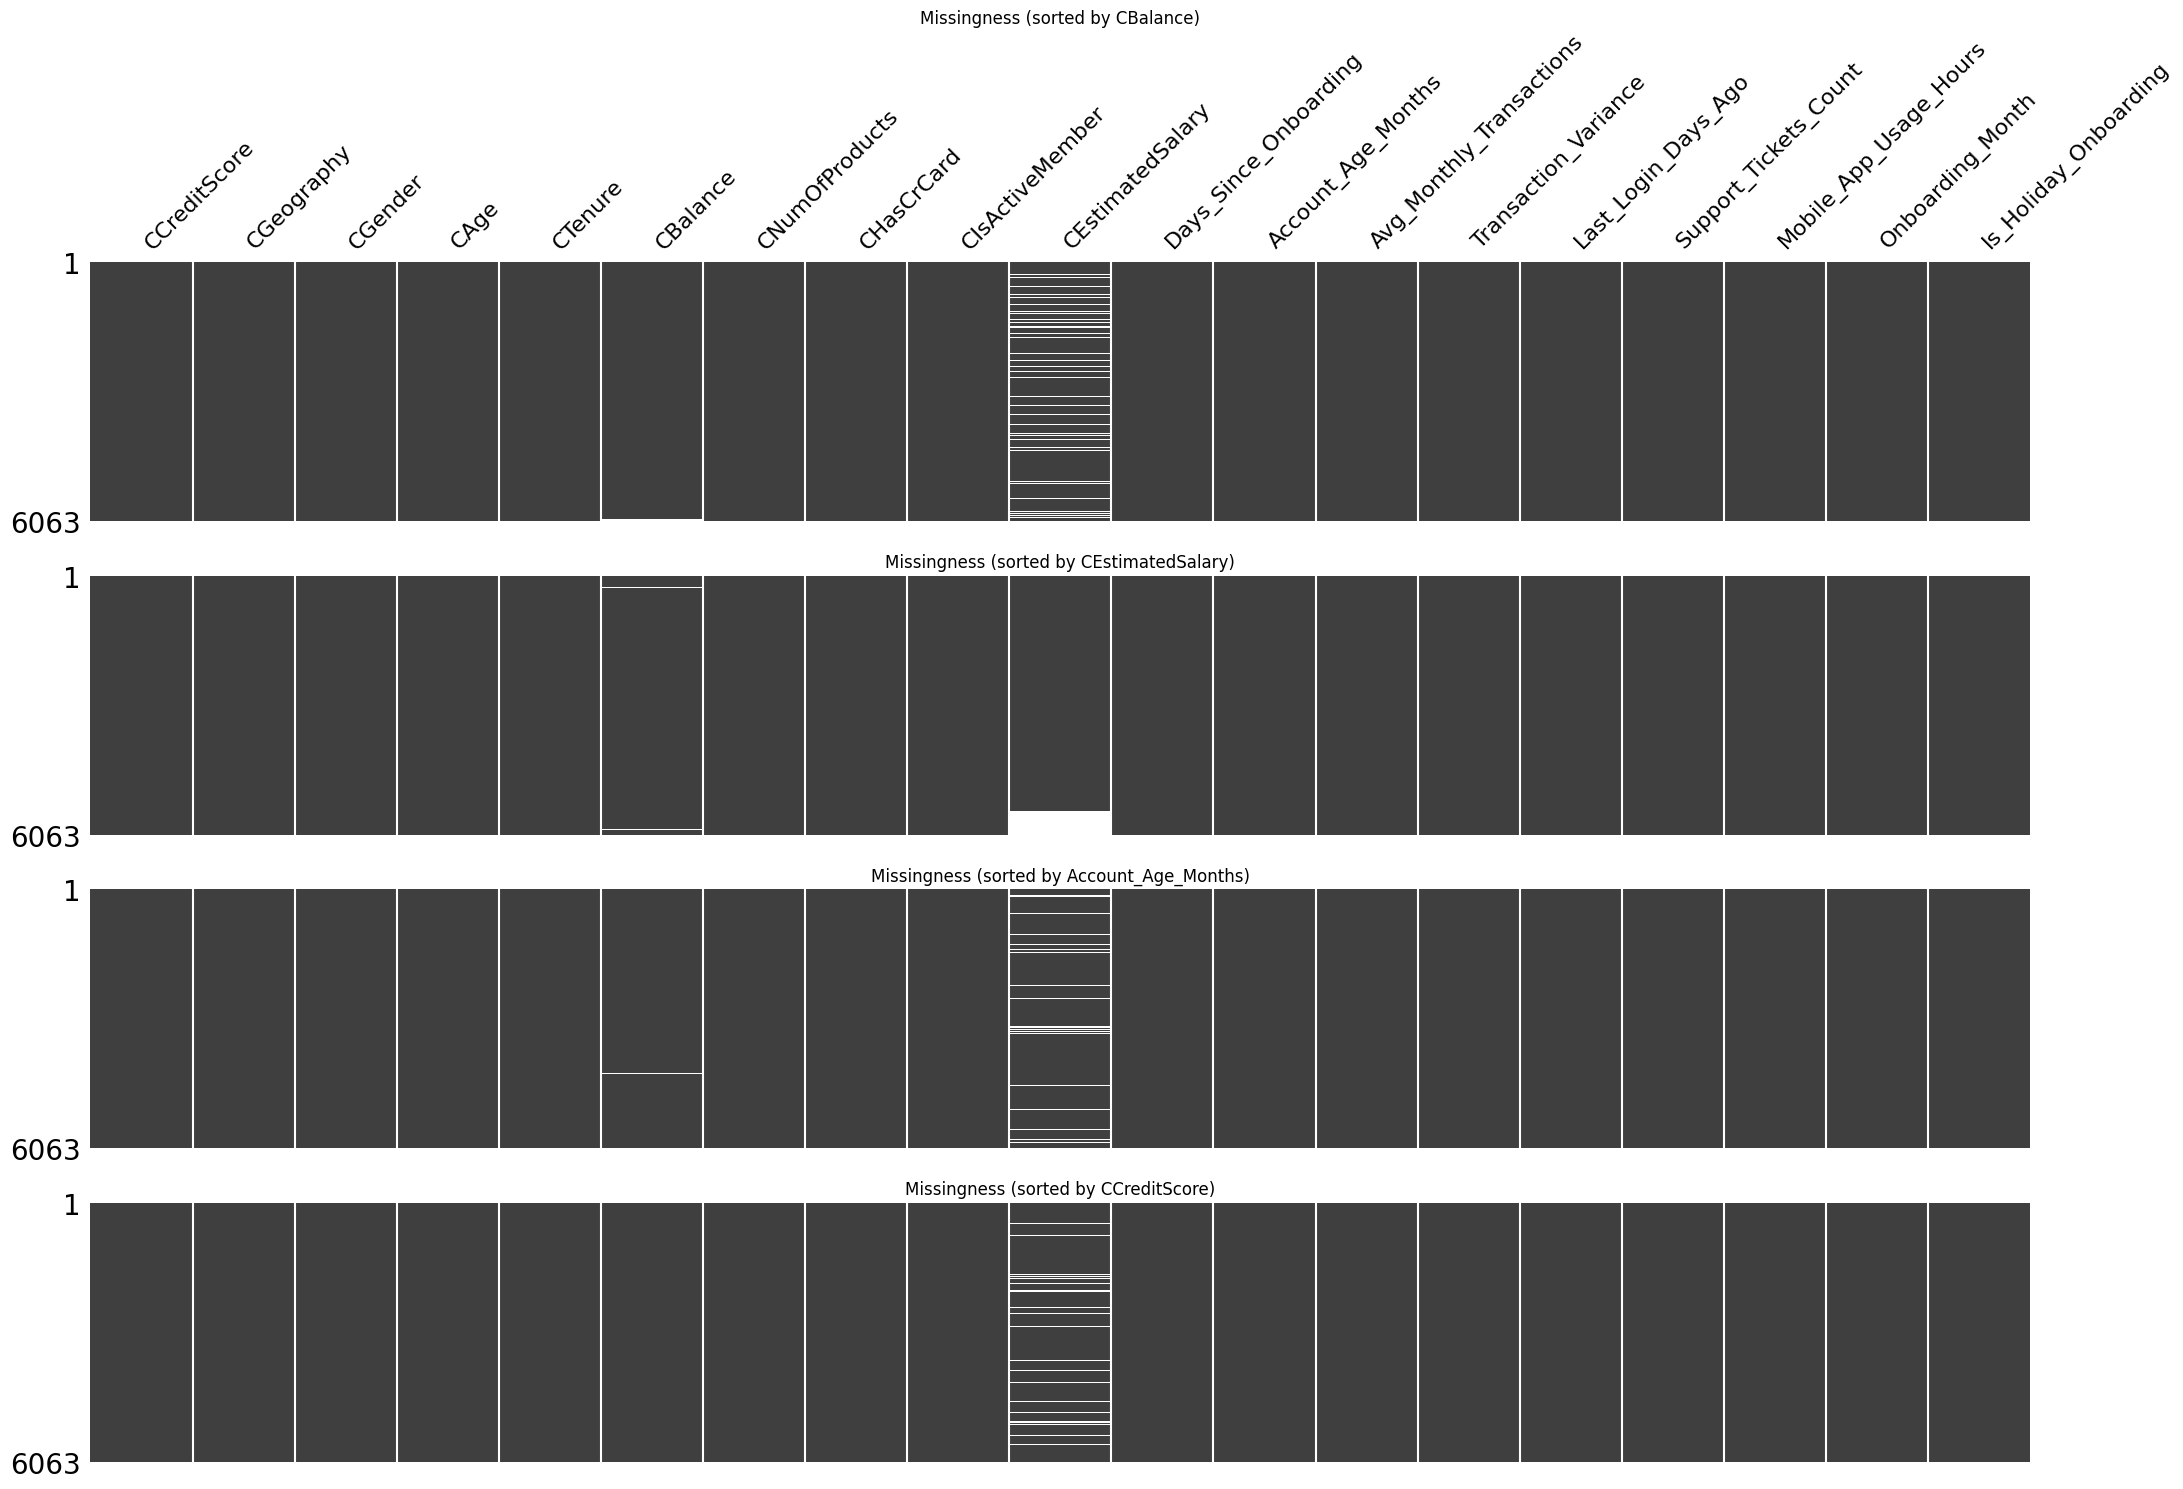

In [178]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(22, 15))  

msno.matrix(X_train_sorted_balance, ax=axes[0])
axes[0].set_title("Missingness (sorted by CBalance)")

msno.matrix(X_train_sorted_salary, ax=axes[1])
axes[1].set_title("Missingness (sorted by CEstimatedSalary)")
axes[1].set_xticklabels([])  # Remove column labels

msno.matrix(X_train_sorted_account_age, ax=axes[2])
axes[2].set_title("Missingness (sorted by Account_Age_Months)")
axes[2].set_xticklabels([])  # Remove column label

msno.matrix(X_train_sorted_credit_score, ax=axes[3])
axes[3].set_title("Missingness (sorted by CCreditScore)")
axes[3].set_xticklabels([])  # Remove column labels

plt.tight_layout()
plt.show()

There do not seem to be any patterns of missingness across the three variables with missing values. It can be assumed that the missing values are missing completely at random (MCAR).
We are going to handle the missingness in a pipeline at a later stage.

### Check for Outliers

When we checked for extreme values earlier we saw the that some distributions of features were skewed. For highly skewed features we have to consider a transformation of the data during the pipeline.

Because we split the dataset we create a function that determines the boundaries for only the training data:

In [179]:
def get_outlier_bounds_sigma(dataset, multiplier=3):
    mean = dataset.mean()
    std = dataset.std()
    lower = mean - (multiplier * std)
    upper = mean + (multiplier * std)
    return lower, upper

Next we are going to detect the outliers in the datasets using the following function:

In [180]:
def detect_outliers(dataset, lower, upper):
    return ((dataset < lower) | (dataset > upper)).sum()

# store outlier bounds
outlier_bounds = {}

In [181]:
for col in numeric_cols:
    lower, upper = get_outlier_bounds_sigma(X_train[col], multiplier=3)
    outlier_bounds[col] = (lower, upper)
    
    # show outliers in both training and test set by only using the bounds from the training data
    outliers_test = detect_outliers(X_train[col], lower, upper)
    outliers_train = detect_outliers(X_test[col], lower, upper)
    print(f"{col}: {outliers_train} outliers (train), {outliers_test} outliers (test)")

CCreditScore: 1 outliers (train), 12 outliers (test)
CAge: 45 outliers (train), 118 outliers (test)
CTenure: 0 outliers (train), 0 outliers (test)
CBalance: 0 outliers (train), 0 outliers (test)
CEstimatedSalary: 0 outliers (train), 0 outliers (test)
Days_Since_Onboarding: 55 outliers (train), 105 outliers (test)
Account_Age_Months: 55 outliers (train), 105 outliers (test)
Avg_Monthly_Transactions: 7 outliers (train), 14 outliers (test)
Transaction_Variance: 42 outliers (train), 93 outliers (test)
Last_Login_Days_Ago: 40 outliers (train), 90 outliers (test)
Support_Tickets_Count: 53 outliers (train), 168 outliers (test)
Mobile_App_Usage_Hours: 47 outliers (train), 120 outliers (test)


Multiple outliers for different variables. We are handling these with winsorization applied in the pipeline below. We use a custom transformer to prevent data leakage.

In [182]:
class OutlierWinsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, multiplier=3):
        self.multiplier = multiplier
        self.bounds_ = {}
        self.n_features_in_ = None
        self.feature_names_in_ = None
    
    def fit(self, X, y=None):
        X = np.array(X)
        for i in range(X.shape[1]):
            mean = np.nanmean(X[:, i])
            std = np.nanstd(X[:, i])
            self.bounds_[i] = (mean - self.multiplier * std, 
                               mean + self.multiplier * std)
        return self
    
    def transform(self, X):
        X = np.array(X).copy()
        for i in range(X.shape[1]):
            lower, upper = self.bounds_[i]
            X[:, i] = np.clip(X[:, i], lower, upper)
        return X
    
    def get_feature_names_out(self, input_features=None):
        """Return feature names (passthrough since we don't change columns)."""
        if input_features is None:
            return np.array([f'x{i}' for i in range(self.n_features_in_)])
        return np.array(input_features)

### Pre-Processing Pipeline

As said before: In order to minimize the risk of data leakage we are going to use a pipeline that includes the following pre-processing steps:
- Handling Missing Values (Imputation)
- Handling Outliers (Winsorization)
- Feature Engineering (One-Hot-Encoding)
- Data Transformation

Ordinal, circular variable (`Onboarding_Month`) that represents a month on a scale from 1-12 and that can show possible seasonal effects. We have to keep this in mind during Feature Engineering. 
Two possibilites:
1. insert dummy variables via one hot encoding for each month => significantly increases the number of features (+11)
2. apply cyclical (sin/cos) encoding => custom transformer needed

Nr 1. could cause problems with the months December and January (12 and 1) that would appear maximally distant when they are actually adjacent, like January and February. For the sake of simplicity we are going to stick with one hot encoding in this case though.

Create separate pipelines for numerical and categorical variables:

In [183]:
cat_transformer = Pipeline(steps=[
    ('imputer_cat', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

Feature Engineering: Encoding variables
We are going to use one-hot encoding for categorical variables, which are defined as follows:

In [184]:
cat_cols = ["CGeography", "CGender", "CHasCrCard" ,"CIsActiveMember", "Is_Holiday_Onboarding", "Onboarding_Month"]

- percentage of missingness is small (<10%) => fill missing values using imputation
- due to small percentage of missingness impact on data quality is limited
- imputation with median to account for skewness of the distribution by preserving central tendency

In [185]:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('outlier', OutlierWinsorizer(multiplier=3)),
    ('power', PowerTransformer(method='yeo-johnson')),
    ('scaler', RobustScaler())
])

We use RobustScaler to standardize the variables to ensure that models which use distance measures (k nearest neighbors) and models that require a common scale in order to apply a penalties (logistic regression) can be applied at a later stage. We use RobustScaler and not StandardScaler because there are plenty of outliers in the dataset and still could be after winsorization.

Because some distributions of variables have a skewed distribution we are applying PowerTransformer at the end of the pipeline to ensure normality. 

In [186]:
# collect all columns num_transformer needs to be applied on
all_numeric_cols = [col for col in X_train.columns if col not in 
                  ["Customer_ID","CLV_Continuous"] + cat_cols]

Master pipeline:

In [187]:
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, all_numeric_cols),
    ('cat', cat_transformer, cat_cols)
],
remainder='passthrough'
)

Next we fit the pipeline on training dataset and transform both training and test set. The pipeline avoids data leakage. For example when winsorizing the thresholds are determined solely from the training data (as we did before when checking for outliers) and applied to both training and test data.

In [188]:
X_train_processed = preprocessor.fit_transform(X_train)
feature_names_train = preprocessor.get_feature_names_out()
# ensure that the test data is transformed in the same way
X_test_processed = preprocessor.transform(X_test)
feature_names_test = preprocessor.get_feature_names_out()

Convert np-array to dataframe:

In [189]:
X_train_processed_df = pd.DataFrame(X_train_processed, columns=feature_names_train)
X_test_processed_df = pd.DataFrame(X_test_processed, columns=feature_names_test)

Distribution of the variables in X_train after preprocessing pipeline:

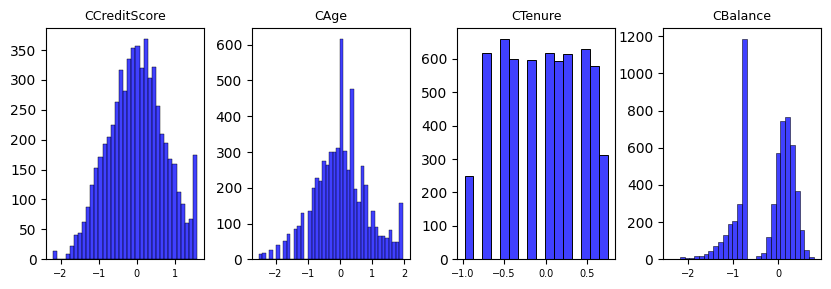

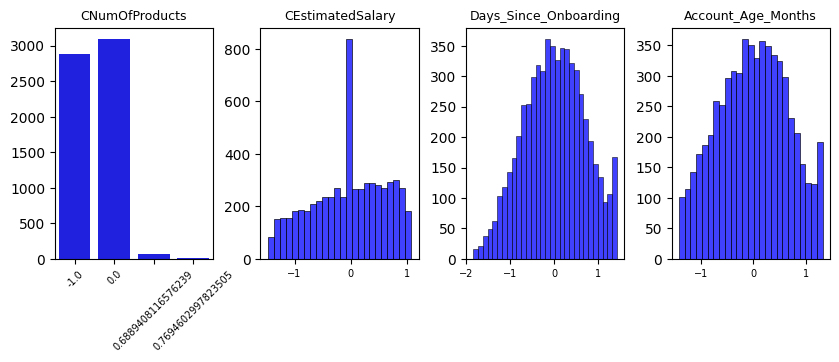

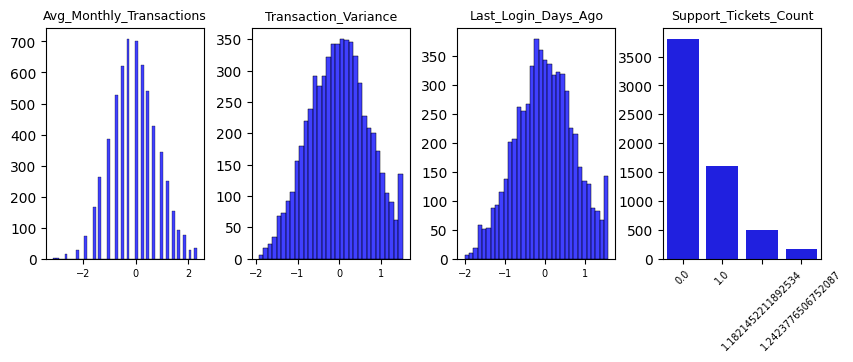

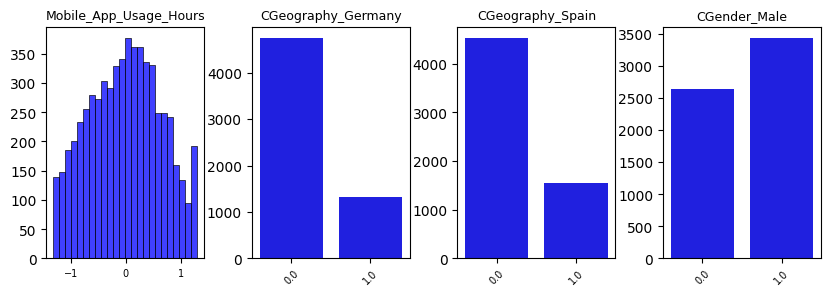

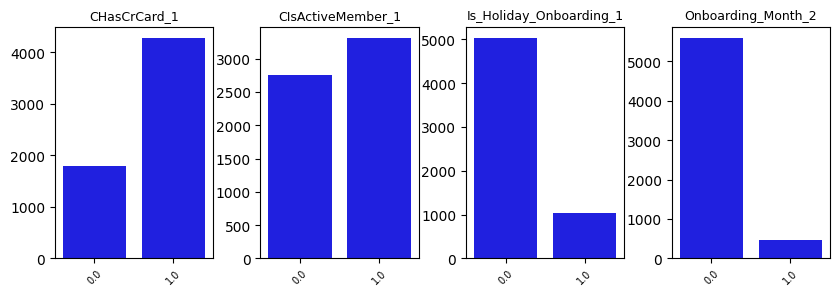

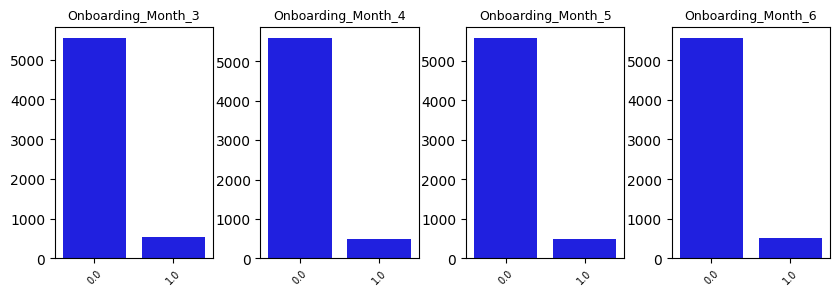

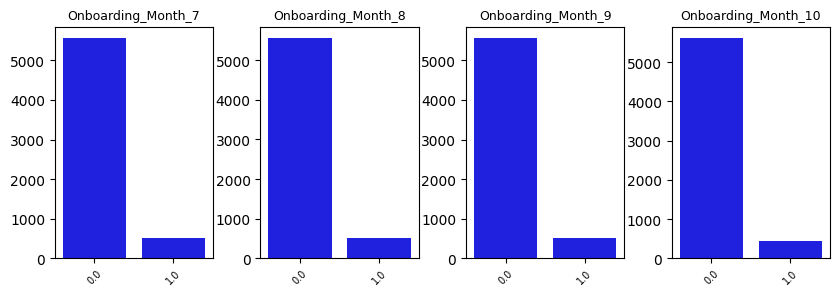

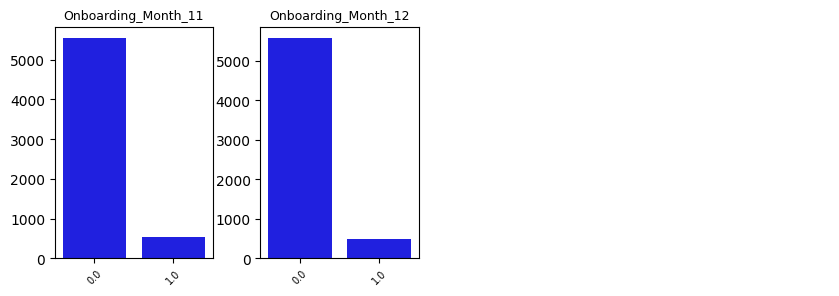

In [190]:
plot_grid(X_train_processed_df, X_train_processed_df.columns.tolist(), ncols=4, fig_height=3)

We can see that most of the skewness and outliers were tackled during scaling and data transformation. We have to keep the transformation using PowerTransformer in mind. If we want to interpret coefficients or feature importance or communicate our findings to stakeholders at a later stage the data has to be transformed back. 

In order for the dataset to be "model-ready" we are going to create a subset that contains the features of the models for the classification task.

In [191]:
model_features = [col for col in X_train_processed_df.columns if col not in 
                  ["remainder__Customer_ID", "remainder__CLV_Continuous"]]

### Check for Multicollinearity

We have to check for multicollinearity  and remove highly correlated features or apply dimensionality techniques to take this into account. To do this we are taking a look at a correlation matrix:

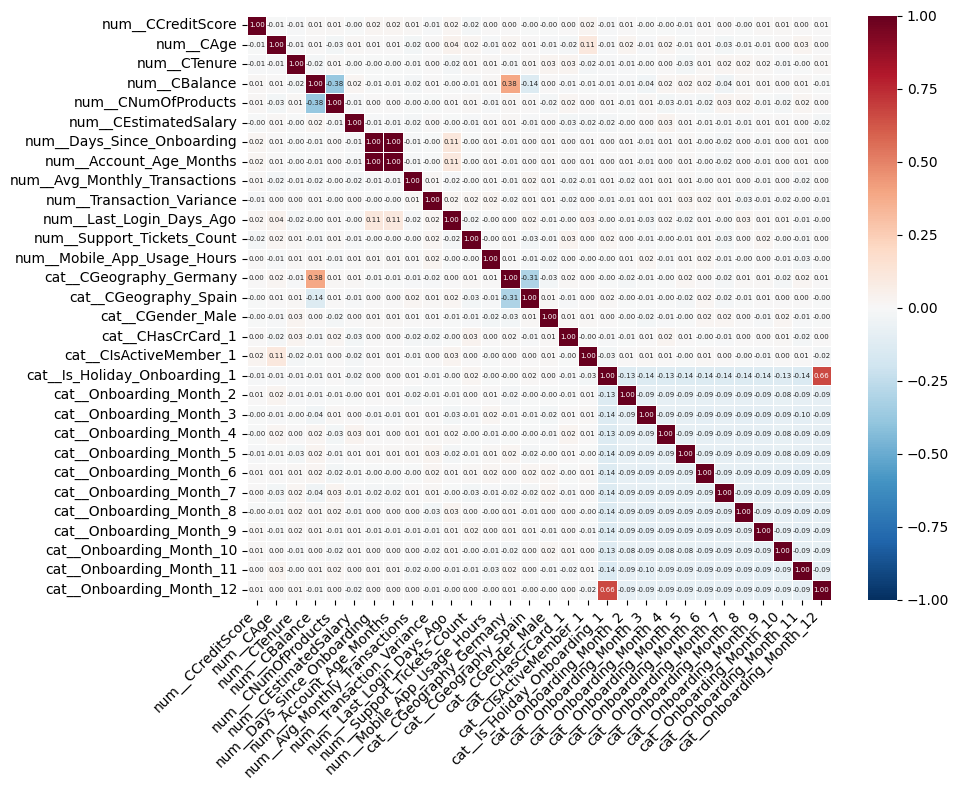

In [192]:
correlation_matrix = X_train_processed_df[model_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt='.2f',              # 2 decimal places instead of many
    cmap='RdBu_r',          # Diverging colormap
    center=0,               # Center at 0
    vmin=-1, vmax=1,        # Fixed scale
    square=True,            # Square cells
    linewidths=0.5,         # Grid lines between cells
    annot_kws={'size': 5}   # Smaller font for annotations
)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Also we can see a perfect positive correlation between `Days_Since_Onboarding` and `Account_Age_Months`. We are going to drop `Days_Since_Onboarding` as recommended in the task description.

In [193]:
model_features.remove('num__Days_Since_Onboarding')
X_train_processed_df = X_train_processed_df.drop(columns=['num__Days_Since_Onboarding'])
X_test_processed_df = X_test_processed_df.drop(columns=['num__Days_Since_Onboarding'])
X_train_processed = X_train_processed_df.values
X_test_processed = X_test_processed_df.values

We are going to double check now by calculating the Variance Inflation Factor (VIF) to check if there really is no significant correlation between the independant variables (features):

In [194]:
correlation_matrix = X_train_processed_df[model_features].corr()

# Identify pairs of features with high collinearity (correlation > 0.8 or < -0.8)
high_corr_features = [(col1, col2, correlation_matrix.loc[col1, col2])
                     for col1 in correlation_matrix.columns
                     for col2 in correlation_matrix.columns
                     if col1 != col2 and abs(correlation_matrix.loc[col1, col2]) > 0.8]

In [195]:
# Convert to a DataFrame for better visualization.
collinearity_df = pd.DataFrame(high_corr_features, columns=["Feature 1", "Feature 2", "Correlation"])
print("\nHighly Correlated Features:\n", collinearity_df)

# Compute Variance Inflation Factor (VIF) for each feature.
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_processed_df[model_features].columns
vif_data["VIF"] = [variance_inflation_factor(X_train_processed_df[model_features].values, i) for i in range(X_train_processed_df[model_features].shape[1])]

# Display top 3 VIF values
print("Top 3 Features by VIF:")
display(vif_data.nlargest(3, "VIF"))


Highly Correlated Features:
 Empty DataFrame
Columns: [Feature 1, Feature 2, Correlation]
Index: []
Top 3 Features by VIF:


,Feature,VIF
17,cat__Is_Holiday_Onboarding_1,3.383
28,cat__Onboarding_Month_12,1.763
22,cat__Onboarding_Month_6,1.762


The VIF-Check supports the findings from the visual inspection. Except for the already removed feature, there are no other highly correlated features in the dataset. The VIF of `cat_Is_Holiday_Onboarding` is slightly higher (3.38) indicating a low/moderate correlation. This makes sense because likely correlates with all `cat__Onboarding_Month` features. The correlation matrix above indicates this as well. Because it is an expectable and not significant correlation we can accept it as it is.

The model features are sufficiently independant. Therefore we can proceed with training and evaluating the classification models.

## Task 2: Build and Evaluate Basic Models

Experiment with different machine learning models to predict customer churn (binary classification 
using the `Churn` target variable).

- Use three different basic machine learning models from lecture 02 (e.g., Decision Trees, k-
Nearest Neighbors, Naive Bayes, or Logistic Regression). 
- Describe your approach to applying each model, including the assumptions and motivations 
behind each choice. 
- Evaluate the performance of the models. 
- Justify which machine learning model you would choose based on the performance results 
from this task. 

Note: No hyperparameter tuning is expected at this stage. 

For the different models we are going use oversampling to take the class imbalance seen at the beginning of Task 1 into account. Oversampling balances the class distribution by increasing the number of instances in the minority class (here: `Churn` == True). We use the SMOTE (Synthetic Minority Over-sampling Technique) from imblearn (imbalanced-learn library) to achieve this because it is a more sophisticated algorithm based on Oversampling that creates additional synthetic instances.

While Oversampling should improve model performance it also comes with a risk of overfitting. Compared to Undersampling, which is another technique to balance a dataset by reducing the instances in the majority class, we do not loose any data using Oversampling. A downside is that training time might increase with Oversampling because the dataset grows in size.

We apply oversampling after splitting the data and only on the training set. This is important because if we would over- or undersample the entries in the test set it would no longer represent the population from which we are drawing observations. Every metric applied on the smote test set later, would no longer be an unbiased measure of peformance on unseen data. Furthermore there is a risk of data leakage when applying over- or undersampling before splitting the dataset.

In [196]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_processed_df[model_features], y_train)

After Oversampling we see the following distribution of the data regarding the two classes:

In [197]:
FinTech.Churn.value_counts()

Churn
0    8021
1     641
Name: count, dtype: int64

Now the classes are completely balanced.

I chose the following models:
1. Decision Trees (easy to apply, non-parametric, non-linear relationships do not affect performance)
    Assumptions of Decision Trees:
    - not sensitive to feature scaling.
    - no distribution assumptions, not influenced by outliers.
    - invariant to monotonic transformations.
    - requires imputation to handle any missing values
2. K-Nearest Neighbors (simple and flexible, assigns class labels based on the majority vote of the k-clostest points in feature space, downside is the parameter k, that can not be easily determined)
    Assumptions of kNN:
    - relies on distance calculations -> highly sensitive to feature scales
    - requires standardization so that all features contribute equally to the distance metric
    - requires imputation to handle any missing values
We set k=3 in this case.
3. Logistic Regression (good performance and easy to interpret)
    Assumptions of Logistic Regression: 
    - assumes linearity
    - normally distributed data 
    - requires standardization

We scaled and transformed the data before to take these assumptions into account.
Create helper function for learning and testing:

In [198]:
def evaluate_model(name, estimator, X_test, y_test, fit=False, X_train=None, y_train=None):
    """
    Args:
        name: Model name for display
        estimator: Model (fitted or unfitted)
        X_test: Test features
        y_test: Test labels
        fit: If True, fit the model first (requires X_train, y_train)
        X_train: Training features (only needed if fit=True)
        y_train: Training labels (only needed if fit=True)
    """
    
    if fit:
        estimator.fit(X_train, y_train)
    
    y_pred = estimator.predict(X_test)
    y_proba = estimator.predict_proba(X_test)[:, 1]

    return {
        "Model": name,
        "Estimator": estimator,
        "Acc": accuracy_score(y_test, y_pred),
        "Prec": precision_score(y_test, y_pred, pos_label=1),
        "Rec": recall_score(y_test, y_pred, pos_label=1),
        "F1": f1_score(y_test, y_pred, pos_label=1),
        "AUC": roc_auc_score(y_test, y_proba),
        "Confusion Matrix": confusion_matrix(y_test, y_pred)
    }

To evaluate the model performance we look at different metrics:

**Accuracy** 
- proportion of all predictions that were correct (both true positives and true negatives)
- can be misleading for imbalanced datasets like ours where churners are a minority. A model predicting "no churn" for everyone would achieve high accuracy but be useless for identifying churners.

**Precision**
- proportion of all model's positive classifications that are actually positive. 
- In our context: of all customers predicted to churn, how many actually churned?

**Recall** (sensitivity or true positive rate) 
- proportion of all actual positives that were classified correctly as positives. 
- In our context: of all customers who actually churned, how many did the model identify?

Both Precision and Recall do not take the true negative values into account. In this business case, false positives (customers predicted to churn but don't) are less costly than false negatives (customers predicted not to churn but do). False negatives represent missed opportunities for retention efforts and could result in financial loss. Therefore, Recall is more important than Precision for this use case.

**F1 Score** 
- harmonic mean of Precision and Recall
- particularly useful to compare models when there is an uneven class distribution

**ROC AUC Score** 
- model's ability to distinguish between classes across all classification thresholds
- score of 0,5 indicates random guessing, 1,0 indicates perfect discrimination
- is threshold-independent
- useful for comparing overall model quality.

Build and fit models:

In [199]:
results_train_test = [
    evaluate_model("Decision Trees (Orig.)", DecisionTreeClassifier(random_state=42, min_samples_leaf=0.04),
                   X_test_processed_df[model_features], y_test, 
                   fit=True, X_train=X_train_smote, y_train=y_train_smote),
    evaluate_model("k-NN (Orig.)", KNeighborsClassifier(n_neighbors=3),
                   X_test_processed_df[model_features], y_test,
                   fit=True, X_train=X_train_smote, y_train=y_train_smote),
    evaluate_model("Logistic Regression (Orig.)", LogisticRegression(solver='lbfgs', max_iter=500),
                   X_test_processed_df[model_features], y_test,
                   fit=True, X_train=X_train_smote, y_train=y_train_smote),
]

In [200]:
# helper function to create comparison dataframe
def create_comparison_df(results, baseline_df=None, show_change=False, baseline_idx=0, compare_idx=1):
    """
    Args:
        results: List of result dicts from evaluate_model()
        baseline_df: Optional existing dataframe to prepend
        show_change: If True, add a row showing relative change between baseline and compared model
        baseline_idx: Index of baseline model for change calculation (default: 0)
        compare_idx: Index of model to compare against baseline (default: 1)
    
    Returns:
        DataFrame with comparison metrics
    """
    df = pd.DataFrame(results)
    # Remove columns not needed for display
    display_cols = ['Model', 'Acc', 'Prec', 'Rec', 'F1', 'AUC']
    df = df[[col for col in display_cols if col in df.columns]]
    
    # Prepend existing results if provided
    if baseline_df is not None:
        baseline_clean = baseline_df[~baseline_df['Model'].str.startswith('Δ vs')]
        df = pd.concat([baseline_clean, df], ignore_index=True)
    
    # Add relative change row if requested
    if show_change:
        # First remove any existing change rows from the entire df
        df = df[~df['Model'].str.startswith('Δ vs')]
        
        metric_cols = ['Acc', 'Prec', 'Rec', 'F1', 'AUC']
        baseline_name = df.loc[baseline_idx, 'Model']
        change_row = {'Model': f'Δ vs {baseline_name} (%)'}
        for col in metric_cols:
            if col in df.columns:
                baseline = df.loc[baseline_idx, col]
                compared = df.loc[compare_idx, col]
                change_row[col] = round((compared - baseline) / baseline * 100, 1)
        df = pd.concat([df, pd.DataFrame([change_row])], ignore_index=True)
    
    # Display the dataframe
    print(tabulate(df.round(3), headers='keys', tablefmt='simple', showindex=False))
    
    return df

In [201]:
df_comparison = create_comparison_df(results_train_test)

Model                          Acc    Prec    Rec     F1    AUC
---------------------------  -----  ------  -----  -----  -----
Decision Trees (Orig.)       0.736   0.159  0.599  0.251  0.766
k-NN (Orig.)                 0.748   0.144  0.49   0.223  0.647
Logistic Regression (Orig.)  0.706   0.158  0.688  0.257  0.751


### Interpretation and Discussion

- All three models show moderate accuracy (70-75%), but this metric is misleading due to class imbalance
- Precision is low across all models (14-16%), meaning many false positives - most customers predicted as churners won't actually churn
- Recall varies significantly (49-69%), indicating different trade-offs in identifying actual churners
- F1 Scores are low (22-26%), reflecting the poor precision-recall balance

**Model Comparison**

Decision Trees:
- Balanced performance with ROC AUC of 0.766 (best among the three)
- Recall of 59.9% - catches about 6 out of 10 churners
- 610 false positives vs. 115 true positives

k-NN:
- Lowest recall (49%) - misses more than half of actual churners
- Lowest ROC AUC (0.647) - weakest discriminative ability
- Most conservative predictions but at the cost of missing churners

Logistic Regression:
- Highest recall (68.8%) - best at identifying actual churners
- Highest F1 Score (0.257) despite lowest accuracy
- Most false positives (704) but also most true positives (132)
- Good ROC AUC (0.751) indicating reasonable ranking ability

We plot the Receiver Operating Characteristics (ROC) to get a further understanding of the models performance.

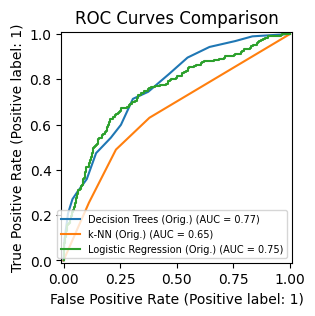

In [202]:
fig, ax = plt.subplots(figsize=(5, 3))
for r in results_train_test:
    RocCurveDisplay.from_estimator(r['Estimator'], X_test_processed_df[model_features], y_test, ax=ax, name=r['Model'])
ax.legend(fontsize=7, loc='lower right')
ax.set_title("ROC Curves Comparison")
plt.show()

Generally we only see skillfull models, because the curves bow up to the top left of the plot in all cases. The KNeighborsClassifier is the worst at predicting which is shown by the shape of the curve. The AUC of kNN is the lowest (0.65). The best predictions are done by the DecisionTreeClassifier with an AUC of 0.77. Logistic Regression performs nearly as good with an AUC of 0.75. According to the ROC-AUC the decision tree classifier should be chosen.

Although Logistic Regression offers a higher F1-score 0,257 than Decision Trees (0,251), we are going to choose the DecisionTreeClassifier for further optimization steps. This is due to the higher ROC AUC, which lets us compare overall model quality.
A downside of Decision Trees is that they can create over-complex trees that do not generalize the data well. There is a risk of overfitting. This is further increased when applying oversampling to the dataset. We have to take this into account in the following steps. 

## Task 3: Optimize the Selected Model

Optimize the best-performing model from Task 2 through hyperparameter tuning. 
- Optimize the performance using advanced techniques from lecture 04 (Note: Choose the 
model that performed best in Task 2). Be sure to analyze whether your model is overfitted or 
underfitted and use cross-validation for evaluation. 
- Describe your approach to tuning the model. Especially, specify the chosen hyperparameters 
and why that. 
- Interpret the performance of the model after optimization and compare it to the initial model 
from Task 2. 
- Justify which final machine learning model you would choose after optimization.

We are now going to apply hyperparameter tuning to optimize the model.
The DecisionTreeClassifier has the following hyperparameters:

In [203]:
results_train_test[0]['Estimator'].get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 0.04,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}

Since there are to many hyperparameters to tune we are going to focus on a selection of five parameters:

| Parameter | Description | Search Range |
|-----------|-------------|--------------|
| `criterion` | Decision criterion, determines the decision criterion that decides how the tree measures the quality of splits | gini or entropy |
| `max_depth` | Maximum depth of each tree, directly controls the complexity of the model: deeper trees can capture more complex patterns, but are prone to overfitting, while shallow trees may underfit| 1 to 8 |
| `min_samples_split` | Minimum samples to split a node, Higher values prevent the tree from making splits based on small subsets of data, which reduces overfitting by avoiding too specific decision rules | 2, 5, 10, 20, 50 |
| `min_samples_leaf` | Minimum samples at a leaf node, Prevents leaves that only represent few samples (noise of the training data) | 1, 2, 4, 10, 20, 0.01, 0.02, 0.04 |
| `max_features` | Features to consider for best split, Limiting this can improve generalization, especially in high dimensional data | 0.2, 0.4, 0.6, 0.8, 1 |

All these five hyperparameters together can control the generalization error of the model. 

We talked about two different algorithms for hyperparameter tuning during this course: Grid Search and Random Search.

Grid Search is a very exhaustive algorithm because it creates candidates from a grid of parameter values and every possible combination of hyperparameters is looked at. Including additional hyperparameters therefore increases training time exponantially. A better method could be Random Search because it only tests randomly selected hyperparameter combinations and not all combinations in the grid.

Because time and computing power are usually limited resources in real-world applications we are going with Random Search in this case. 

As in the prior chapter we are using the receiver operator characteristic - area under curve (ROC AUC) as the metric when searching the best parameters. Do do this we are going to create a scorer with the ROC AUC:

In [204]:
scorer = make_scorer(roc_auc_score)

Next we are going to set a parameter distribution:

In [205]:
param_dist= {
'criterion' :['gini', 'entropy'],
'max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
'min_samples_split': [2, 5, 10, 20, 50],
'min_samples_leaf': [1, 2, 4, 10, 20, 0.01, 0.02, 0.04],
'max_features': [0.2, 0.4, 0.6, 0.8, 1]
}

Instantiate 5-fold RandomizedSearchCV object with 100 iterations and fit object to the training data:

In [206]:
clf_tree_rs = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), param_dist, scoring=scorer, return_train_score=True, random_state=42, n_iter=100, cv=5)
# fit model
clf_tree_rs.fit(X_train_smote, y_train_smote);

Print parameters:

In [207]:
print("Best parameters:", clf_tree_rs.best_params_)

Best parameters: {'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': 0.8, 'max_depth': 8, 'criterion': 'gini'}


Next we are going to analyze whether the optimized model is overfitted or underfitted using the cross validation results:

In [208]:
cv_results_df = pd.DataFrame(clf_tree_rs.cv_results_)

cv_results_df['train_test_gap'] = (cv_results_df['mean_train_score'] - 
                                 cv_results_df['mean_test_score'])

top_models = cv_results_df.nsmallest(5, 'rank_test_score')[
    ['mean_train_score', 'mean_test_score', 
     'std_test_score', 'train_test_gap']
]
print(top_models)

    mean_train_score  mean_test_score  std_test_score  train_test_gap
98             0.908            0.887           0.022           0.021
37             0.909            0.886           0.023           0.023
93             0.902            0.883           0.024           0.019
81             0.907            0.882           0.023           0.025
63             0.899            0.882           0.021           0.017


By looking at the models with the highest `mean_train_score` we can analyze whether the model is overfitting or underfitting.

The `train_test_gap`, which is the difference between the performance of the model on training and test data, is <0,1 for the top performing models. This shows that there is only a small gap between the performance on the training and test data and that there is only minimal overfitting.

`std_test_score` shows the variance of the scores across the five CV folds with a specific parameter set. A low variance indicates consistent performance across all folds. This score ranges from 0,019 to 0,025 for the top performing models, which means that the models offer good stability.

As a last step we are going to interpret the performance of the model after optimization and compare it to the inital model from Task 2:

In [209]:
tuning_comparison = [
    results_train_test[0],  # Decision Tree baseline
    evaluate_model("Decision Trees (Tuned)", clf_tree_rs, 
                   X_test_processed_df[model_features], y_test)
]

In [210]:
df_tuning_comparison = create_comparison_df(tuning_comparison, show_change=True)

Model                               Acc    Prec     Rec      F1     AUC
-------------------------------  ------  ------  ------  ------  ------
Decision Trees (Orig.)            0.736   0.159   0.599   0.251   0.766
Decision Trees (Tuned)            0.831   0.228   0.542   0.321   0.762
Δ vs Decision Trees (Orig.) (%)  12.9    43.8    -9.6    28      -0.5


Interpretation:

We can see that the tuned model offers mixed results:
- Accuracy increases by 12,9 %
- Precision increases by 43,8 %
- Recall decreases by 9,6 %
- F1 Score increases by 28 %
- ROC AUC score decreases by 0,5 %

In summary this means that the tuned model makes correct predicitons more frequently and offers fewer false positives. As a trade-off recall decreased, which means that actual churners are detected less often. The higher F1 score indicates more balance between precision and recall. The ROC AUC score is almost the same.
All in all the tuned model predicts actual churners less frequently, but more accurately when it does. It is more conservative than the baseline model from task 2. 

Because Customer Churn Prediction (Identify customers who are likely to leave the platform) is the main analytical challenge, Recall is more important than precision, as noted before. Ultimately it depends on the relative cost of missed churners vs the cost of wasted resources on false positives. 

To decide we assume that the relative cost of missed churners is higher and therefore choose the baseline model from Task 2.

## Task 4: Apply an Ensemble Learning Technique

Ensemble learning combines multiple models to improve overall performance. In this task, you will 
explore whether using an ensemble technique improves your performance. 
- Use one ensemble learning technique (from lecture 05). Explain and describe your approach. 
Evaluate whether this approach leads to better performance than the models from Tasks 2 
and 3. Be sure to analyze if the ensemble model is overfitted or underfitted. 
- Describe your approach to using and tuning the ensemble model, including the 
hyperparameters. 
- Compare the performance of the ensemble model to the best model from Task 3 and use 
appropriate evaluation metrics.

Based on the model we used before, the decision tree classifier, we are going to use Random forests, which is an ensemble of decision trees. It is equivalent to a bag of decision trees.

In [211]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
#fit model
rnd_clf.fit(X_train_smote, y_train_smote);
rnd_clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': 16,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [212]:
tuning_comparison_ensemble = [
    evaluate_model("Random Forest (Orig.)", rnd_clf, 
                   X_test_processed_df[model_features], y_test)
]

Model performance and comparison to models from task 2 and 3:

In [213]:
df_tuning_comparison_ensemble = create_comparison_df(
    tuning_comparison_ensemble, 
    baseline_df=df_tuning_comparison,
    show_change=True,
    baseline_idx=0,  # Decision Tree (Baseline)
    compare_idx=2    # Random Forest (Orig.) - 3rd row after concat
)

Model                               Acc    Prec      Rec      F1    AUC
-------------------------------  ------  ------  -------  ------  -----
Decision Trees (Orig.)            0.736   0.159    0.599   0.251  0.766
Decision Trees (Tuned)            0.831   0.228    0.542   0.321  0.762
Random Forest (Orig.)             0.871   0.289    0.51    0.369  0.816
Δ vs Decision Trees (Orig.) (%)  18.4    82.2    -14.8    47.2    6.5


The Random Forest Classifier outperforms both Decision Trees on most metrics:

- Highest accuracy (87,1 %) - makes fewer overall errors
- Highest precision (28,9 %) - most reliable when predicting churn
- Highest F1 Score (0,369) - best precision-recall balance
- Highest ROC AUC (0,816) - best discrimination ability between classes

However, the Baseline Decision Tree has the highest Recall (59.9%):

- Catches the most actual churners
- Trade-off: many false positives (low precision)

Given my earlier statement that recall is important for this business problem, random forest does not seem as the ideal choice. But we have to keep in mind that it offers the best overall performance (ROC AUC). While it catches fewer churners than the baseline (untuned decision tree) its higher precision score means retention efforts are better targeted. 
Again, the costs of the decisions have to be known to make a solid decision here.

Baseline RandomForestClassifier parameters before hyperparameter tuning:

### Hyperparameter Tuning Approach

We will tune the following hyperparameters:

| Parameter | Description | Search Range |
|-----------|-------------|--------------|
| `n_estimators` | Number of trees in the forest | 50-300 |
| `max_depth` | Maximum depth of each tree | 1-8 | 
| `min_samples_split` | Minimum samples to split a node | 2, 5, 10, 20, 50 |
| `min_samples_leaf` | Minimum samples at a leaf node | 1, 2, 4, 10, 20, 0.01, 0.02, 0.04 |
| `max_features` | Features to consider for best split | 0.2, 0.4, 0.6, 0.8, 1 |
| `bootstrap` | Whether to use bootstrap samples | True, False |

We use RandomizedSearchCV with 5-fold cross-validation and roc_auc_score as the scoring metric (consistent with previous tasks).


In [214]:
# Define parameter grid
param_dist = {
    'n_estimators': [50, 100, 150, 200, 250, 300],
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
    'min_samples_split': [2, 5, 10, 20, 50],
    'min_samples_leaf': [1, 2, 4, 10, 20, 0.01, 0.02, 0.04],
    'max_features': [0.2, 0.4, 0.6, 0.8, 1],
    'bootstrap': [True, False]
}

# RandomizedSearchCV
rf_random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring=scorer,
    return_train_score=True,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_random_search.fit(X_train_smote, y_train_smote)

print("Best parameters:", rf_random_search.best_params_)
print("Best CV F1 score:", rf_random_search.best_score_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'n_estimators': 150, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_features': 0.2, 'max_depth': 7, 'bootstrap': False}
Best CV F1 score: 0.9200229205257753


In [215]:
rf_cv_results_df = pd.DataFrame(rf_random_search.cv_results_)

rf_cv_results_df['train_test_gap'] = (rf_cv_results_df['mean_train_score'] - 
                                 rf_cv_results_df['mean_test_score'])

rf_top_models = rf_cv_results_df.nsmallest(5, 'rank_test_score')[
    ['mean_train_score', 'mean_test_score', 
     'std_test_score', 'train_test_gap']
]
print(rf_top_models)

print(f"Median train-test-gap: {rf_cv_results_df['train_test_gap'].median()}")

    mean_train_score  mean_test_score  std_test_score  train_test_gap
6              0.932            0.920           0.025           0.012
5              0.909            0.901           0.021           0.007
18             0.908            0.892           0.023           0.015
8              0.897            0.890           0.023           0.007
16             0.893            0.886           0.018           0.007
Median train-test-gap: 0.005854884550278827


By looking at the models with the highest `mean_train_score` we can analyze whether the model is overfitting or underfitting.

The `train_test_gap`, which is the difference between the performance of the model on training and test data, is <0,1 for the top performing models. The median gap is 0,0058. This shows that there is only a small gap between the performance on the training and test data and that there is only minimal overfitting.

`std_test_score` shows the variance of the scores across the five CV folds with a specific parameter set. A low variance indicates consistent performance across all folds. This score ranges from 0,018 to 0,025 for the top performing models, which means that the models offer good stability.

In [216]:
tuning_comparison_ensemble.append(
    evaluate_model("Random Forest (Tuned)", rf_random_search, 
                   X_test_processed_df[model_features], y_test)
)

In [217]:
df_tuning_comparison_ensemble = create_comparison_df(
    tuning_comparison_ensemble, 
    baseline_df=df_tuning_comparison,
    show_change=True,
    baseline_idx=2,  # Random Forest (Orig.) 
    compare_idx=3    # Random Forest (Tuned.)
)

Model                             Acc    Prec     Rec     F1     AUC
------------------------------  -----  ------  ------  -----  ------
Decision Trees (Orig.)          0.736   0.159   0.599  0.251   0.766
Decision Trees (Tuned)          0.831   0.228   0.542  0.321   0.762
Random Forest (Orig.)           0.871   0.289   0.51   0.369   0.816
Random Forest (Tuned)           0.886   0.319   0.479  0.383   0.816
Δ vs Random Forest (Orig.) (%)  1.7    10.5    -6.1    3.9    -0


The tuned Random Forest Classifier outperforms both Decision Trees and the untuned Random Forest Classifier on most metrics:

- Highest accuracy (88,6 %) - makes fewer overall errors
- Highest precision (31,9 %) - most reliable when predicting churn
- Highest F1 Score (0,383) - best precision-recall balance

However, compared to the untuned Random Forest Classifier the ROC AUC score remains unchanged (0,816). Furthermore the Recall (47,9 %) is the lowest compared to the three other models. 
The Baseline Decision Tree still has the highest Recall (59.9%). 

Again we can see the trade-off that we already described at the end of task 3: The more sophisticated the model, the lower the Recall, but the higher the overall model performance.


### Conclusion

**Performance Comparison:**
- The tuned Random Forest ensemble offers overall increased model performance compared to the tuned Decision Tree from Task 3
- Test F1 Score: Tuned Decision Tree = 0,321 vs Tuned Random Forest = 0,383
- Test ROC-AUC: Tuned Decision Tree = 0,762 vs Tuned Random Forest = 0,816

**Overfitting Analysis:**
- Median Train-Test gap: 0,005854884550278827
- The model is not overfitted based on the gap between training and test performance

**Why Random Forest Works:**
- Random Forest reduces variance by averaging multiple trees
- Each tree is trained on a bootstrap sample with random feature subsets
- This ensemble approach helped generalize better than a single decision tree

**Final Recommendation:**
Based on the evaluation metrics, the tuned Random Forest Classifier should be chosen as the final model because it offers the best overall model performance. It can be assumed that it generalizes best and offers the best balance between a fairly high true positive rate (Recall) and Precision.